# Training for Marathon Swimming - An Exploratory Analysis with SQL and Seaborn

I've successfully trained for and completed multiple marathon (anything over 10km) and "ultramarathon" (definition unclear) swims over the past few years. Needless to say that these all came with their own challenges and required significant training commitments. Training for an event typicallly takes me anywhere from 3-6 months of a strict regimen consisting of pool swimming, open water swimming, and lifting.

<div style="display: flex; gap: 24px; align-items: flex-start; justify-content: center;">
  <figure style="text-align: center; margin: 0;">
    <img src="images/ec_map.jpeg" alt="English Channel map" width="400"/>
    <figcaption>Map of my English Channel crossing in August 2025</figcaption>
  </figure>

  <figure style="text-align: center; margin: 0;">
    <img src="images/rthi.jpeg" alt="RTHI chart" width="400"/>
    <figcaption>Me (yellow cap on the left) doing a long swim in Tomales Bay, CA in August 2024</figcaption>
  </figure>
</div>

At the same time, I am a neurotic user of my Garmin fitness watch - I use it to track all of my activities whether I am actively training for something or not. A while back, I set up a [data pipeline](https://github.com/andrew-cotter/garmin_db) that takes activity summaries from my Garmin account and stores them in a personal database. I've used it previously to set up a [water temperature tracker](https://sfbaytemp.streamlit.app) for the San Francisco Bay.

Now, I am looking for a job ([hire me plz](https://linkedin.com/in/a-cotter)). I've got a lot of free time, and many of the jobs I'm seeing want me to show that I have experience with SQL. That brings me here, to do a deep dive on the data that my Garmin watch has been collecting over the years to give you an idea of what training for marathon swimming looks like (and hopefully help land me a new job.)

The only ground-rule that I set for myself with this is that I need to focus on data manipulation in SQL instead of my preferred pandas. Therefore, you will see a lot of SQL in this report, along with some seaborn and matplotlib for data visualization. No pandas, other than turning the query results into dataframes for plotting.

In [1]:
import pymysql
import toml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def query_db(query, conn):
    """Helper function to run queries"""
    with conn.cursor() as cur:
        cur.execute(query)
    result = cur.fetchall()
    df = pd.DataFrame(result, columns=[i[0] for i in cur.description])
    return df

In [3]:
# Load secrets
secrets = toml.load(".streamlit/secrets.toml")["connections"]["mysql"]

# Connect to the mysql database
conn = pymysql.connect(
    host=secrets["host"],
    port=secrets["port"],
    database=secrets["dbname"],
    user=secrets["username"],
    password=secrets["password"]
)

***

## A First Look

Now that we have some logistics out of the way, lets get to our first set of data. With this query, I will pull all of my activities from 2022 to 2025 and categorize them by the three main activity types - open water swimming, pool swimming, and lifting. 

Data that I want about these activities includes:
 - What year they were recorded
 - The duration of each activity
 - The distance of each swim

In [4]:
df = query_db("""
    SELECT 
        activityName,
        CASE
            WHEN activityName LIKE '%Open Water%' THEN 'Open Water Swim'
            WHEN activityName LIKE '%Swim%' AND activityName NOT LIKE '%Open Water%' then 'Pool Swim'
            WHEN activityName LIKE '%Strength%' OR activityName LIKE '%Weight%' then 'Lifting'
            ELSE NULL
        END AS type, 
        year(startTimeLocal) AS year, 
        CAST(duration AS FLOAT)/3600 duration_hr, 
        CAST(distance AS FLOAT) distance 
    FROM defaultdb.activities
    HAVING type IS NOT NULL 
    AND year > 2021
    """,
    conn
)


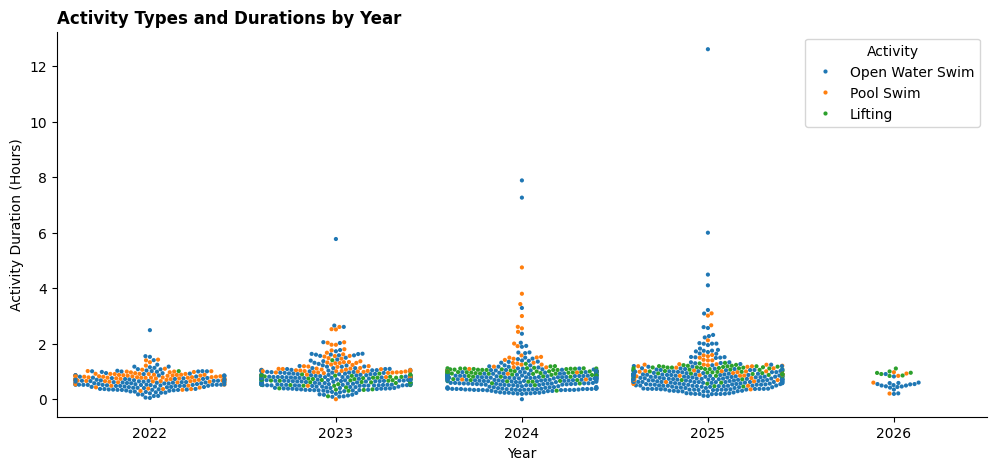

In [5]:
fix, ax = plt.subplots(figsize=(12,5))

plot = sns.swarmplot(
    data = df,
    x="year",
    y="duration_hr",
    hue = "type",
    size=3,
)
sns.despine()

plt.ylabel("Activity Duration (Hours)")
plt.xlabel("Year")
plt.legend(title="Activity")
plt.title("Activity Types and Durations by Year", loc="left", fontweight="bold")

plt.show()

My first real marathon swim was in August of 2023, and is repreented by the ~6hr blue dot that is clearly separated from the rest of the activities for that year. Similar stories for 2024 and 2025, my main events are pretty clearly separated from all of the training and leisure swimming for that year. In 2024, I had two events of similar duration - 7.5-8 hours, and in 2025 my big swim took 12.5 hours.

Each year has a plethora of activites at or below the 1 hour mark, which adds a bit of visual noise to this plot. I will address that in the next section.

***

## Focusing on "Training Swims"

The plot abovie is stretched quite a bit due to this query containing the long swims I did in each year. Since this analysis is focused on training specifically, I want to omit those.

Additionally, for each year, I will also omit every activity that I did *after* my longest swim of the year. I tend to ramp my activity way down after I've completed my long swim for the year, mostly getting exercise in for manintenance and social benefits. Getting rid of these will help remove some of the bloated bottom end of each year.

Finally, I'm going to skip 2022 since I didn't do a marathon swim that year as well as 2026 due to a lack of data so far, I will likely update this later on in the year.

In [6]:
query = """
WITH longestSwims AS(
    SELECT 
        YEAR(startTimeLocal) as yr,
        max(CAST(duration as FLOAT)) as duration
    FROM defaultdb.activities
    WHERE activityName LIKE '%Open Water%'
    GROUP BY YEAR(startTimeLocal)
),
longSwimDate AS(
    SELECT 
        startTimeLocal longSwimDay, 
        YEAR(startTimeLocal) as year 
    FROM defaultdb.activities
    WHERE duration IN (
        SELECT duration FROM longestSwims
    )
),
allTraining AS(
    SELECT 
        startTimeLocal, 
        YEAR(startTimeLocal) as year, 
        CAST(duration as FLOAT)/3600 duration_hr,
        CAST(distance as FLOAT) distance,
        activityName,
        CASE
            WHEN activityName LIKE '%Open Water%' THEN 'Open Water Swim'
            WHEN activityName LIKE '%Swim%' AND activityName NOT LIKE '%Open Water%' then 'Pool Swim'
            WHEN activityName LIKE '%Strength%' OR activityName LIKE '%Weight%' then 'Lifting'
            ELSE NULL
        END AS type
    FROM defaultdb.activities
    HAVING type IS NOT NULL 
    AND year BETWEEN 2023 AND 2025
)
SELECT 
    a.startTimeLocal startTimeLocal,
    DAYOFYEAR(a.startTimeLocal) doy,
    DAYNAME(a.startTimeLocal) dayOfWeek,
    TIME_TO_SEC(TIME(a.startTimeLocal)) / 3600 AS time,
    CAST(a.year AS CHAR(10)) year,
    a.type type,
    a.duration_hr duration_hr,
    SUM(a.duration_hr) OVER(PARTITION BY a.year ORDER BY a.startTimeLocal) cumulative_duration,
    a.distance distance 
FROM allTraining a
JOIN longSwimDate d
ON a.year=d.year
WHERE a.startTimeLocal<d.longSwimDay
"""

df=query_db(query, conn)


There's a lot to this query. 
First, there are 3 CTE's used:
 - ```longSwims``` - identify my longest swims in each year by duration.
 - ```longSwimDate``` - use the distances from ```longSwims``` to look up the date and time of those swims.
 - ```allTraining``` - get useful information about all of my activities in years 2023-2025, and categorize them by type.

The final query uses the dates in ```longSwimDate``` to filter my activities to just those that came before the longest swims in 2023-2025. Aside from basic information such as activity type, date, duration, distance, etc... I also grabbed a few pieces of information that I can use in the exploratory analysis, including:
 - day of the year
 - day of the week
 - activity start time (hour of day)
 - cumulative training hours per year

First, let's return to the swamplot for this filtered data to get a general sense of the trends.

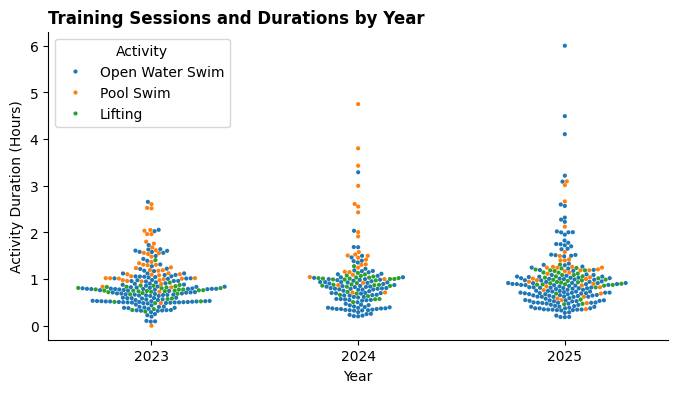

In [7]:
fix, ax = plt.subplots(figsize=(8,4))

plot = sns.swarmplot(
    data=df,
    y="duration_hr",
    x = "year",
    hue="type",
    size=3  # Treat year as categorical by converting to string
)
sns.despine()

plt.ylabel("Activity Duration (Hours)")
plt.xlabel("Year")
plt.legend(title="Activity")
plt.title("Training Sessions and Durations by Year", loc="left", fontweight="bold", )

plt.show()


2023 - Lots of swims under 1 hour, most over 1 hour are in the pools. Longest training swim under 3 hours.
2024 - Longer training swims than 2023, mostly in the pool. 5 hour pool workout
2025 - Longer training swims than 2024, mostly in open water. 6 hour open water swim.

Number of lifting activities remains relatively stable throughout the three years.

Next, I will break this chart out by activity type to see if there are any trends that are hidden here by the sheer volume of data.

Text(0.11, 1, 'Training Sessions and Durations by Year')

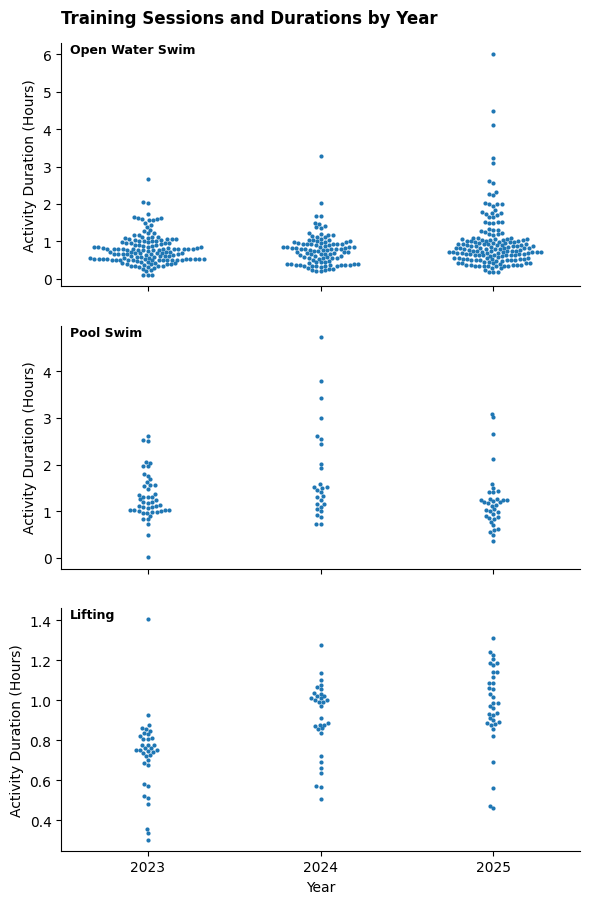

In [8]:
g = sns.FacetGrid(
    df, 
    row = "type", 
    height=3, 
    aspect=2, 
    sharey=False
)
plot=g.map(
    sns.swarmplot,
    "year",
    "duration_hr",
    size=3  
    )

g=g.set_ylabels("Activity Duration (Hours)").set_xlabels("Year")

#Subplot titles
g.set_titles("")
for ax, day in zip(g.axes.flat, g.row_names):
    ax.text(
        x=-0.45, 
        y=ax.get_ylim()[1],  # near top
        s=day, 
        ha="left", 
        va="top",
        fontsize=9,
        fontweight="bold"
    )

#Main title    
g.fig.suptitle(
    "Training Sessions and Durations by Year", 
    fontweight="bold",
    x=0.11,
    y=1,
    ha="left"
    )

Looking at the data broken out this way, a few trends become very clear:
 - I did many more long pool swims and fewer open water swims in 2024. The reasons for this will become apparent later on.
 - My lifting volume was pretty consistent between the three years, but my sessions in 2025 were longer on average.


 ***

## Putting in the Hours
Next, lets take a look at how my years progressed in terms of training volume by plotting the total number of training hours over the years up until the big events.

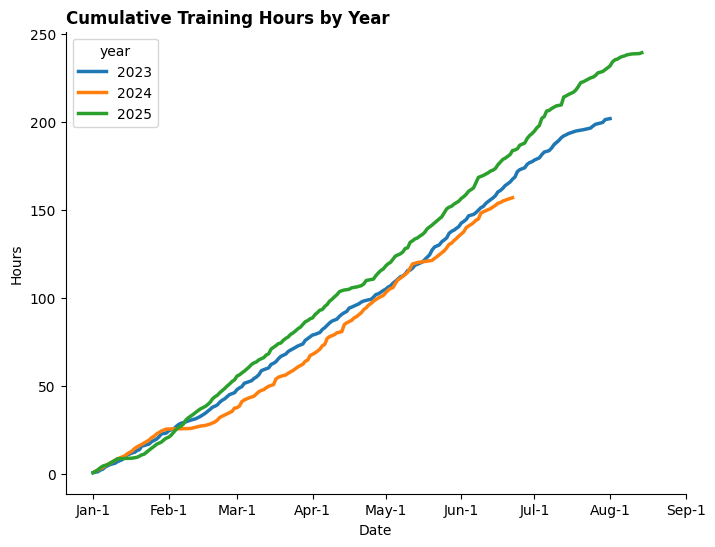

In [9]:
fix, ax = plt.subplots(figsize = (8,6))
plot = sns.lineplot(
    data=df,
    x="doy",
    y="cumulative_duration",
    hue="year",
    linewidth=2.5
)
sns.despine()

ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244])
ax.set_xticklabels(
    [
        "Jan-1",
        "Feb-1",
        "Mar-1",
        "Apr-1",
        "May-1",
        "Jun-1",
        "Jul-1",
        "Aug-1",
        "Sep-1",
    ]
)
plt.ylabel("Hours")
plt.xlabel("Date")
plt.title("Cumulative Training Hours by Year", loc="left", fontweight="bold")

plt.show()

A few observations on this plot:
 - The outlier of these 3 lines is 2024. 
   - It ends the earliest because the main event that I had that were was much earlier than in the typical year - late June in 2024 vs early to mid-August in 2023 and 2025.
   - Due to this early date, 2024 also starts out with a slightly higher volume in January than the other years. However, it flattens out in February due to an injury (broken jaw) that prevented me from doing any physical activity for about a month.
   - Another side-effect of this early date was needing to shift all of my swimming volume earlier in the year by a couple of months. The water in the San Francisco Bay is obviously colder during the winter, and the swim that I was preparing for was particularly warm. Therefore, I did most of my long training swims in the pool, explaining a trend that was noted in the swarmplots above.
 - 2025 starts out slow in January before quickly becoming the highest volume year of the three by a pretty wide margin.
 - 2023 is still a high volume year despite the big event I was training for being the shortest. Perhaps I was a bit neurotic in preparing for my first marathon swim.

One might wonder where I find the time to fit all of this training in considering I had a full-time job throughout. The next plot shows when during the week I did my training.

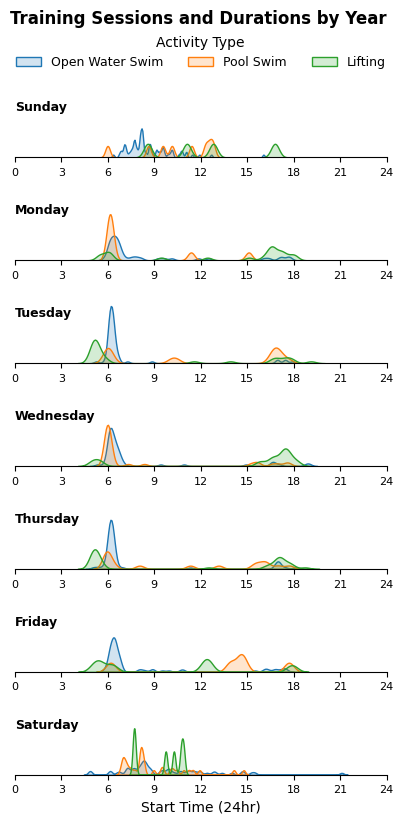

In [10]:
day_order = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday"
]
g = sns.FacetGrid(
    df,
    row="dayOfWeek",
    hue="type",
    row_order=day_order,
    aspect=4,
    height=1.1,
    sharex=True
)
g.map(
    sns.kdeplot,
    "time",
    fill=True,
    alpha=0.2,
    bw_adjust=0.1
)

#Custom Facet Titles
g.set_titles("")
for ax, day in zip(g.axes.flat, g.row_names):
    ax.text(
        x=0, 
        y=ax.get_ylim()[1]*0.95,  # near top
        s=day, 
        ha="left", 
        va="top",
        fontsize=9,
        fontweight="bold"
    )

#Main plot title
g.fig.suptitle(
    "Training Sessions and Durations by Year", 
    fontweight="bold",
    x=0.11,
    y=1.07,
    ha="left"
    )

#Formatting
g.set(
    yticks=[], 
    ylabel=""
    )
g.despine(left=True)

for ax in g.axes.flat:
    ax.tick_params(labelbottom=True, labelsize=8)
    ax.set_xticks([0,3,6,9,12,15,18,21,24])
    ax.set_xticklabels([0,3,6,9,12,15,18,21,24])
plt.xlabel("Start Time (24hr)")

#Legend
handles, labels = g.axes[0,0].get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    title="Activity Type",
    loc="upper center",
    bbox_to_anchor=(0.5, 12.5),  # centered above
    ncol=len(labels),             # horizontal layout
    frameon=False,
    fontsize=9,
    title_fontsize=10
)

plt.show()

As you can see, I really like training in the early morning. 6am was my most popular time Monday-Friday, especially for open water swimming. I enjoy the morning conditions in the San Francisco Bay (typically less wind) more than the afternoon and evening, not to mention getting to my swimming spot is more of a headache with afternoon traffic.

Lifting is a bit more spread out during the week, I remember years where I would wake up at an ungodly hour to swim **and** lift before going to work, especially in 2023. However, I moved in 2024 to a location where going to the gym was much more convenient, and I therefore shifted to lifting after work.

My activities are much more spread throughout the day on weekends. However, the vast majority of my swimming was still done in the mornings - just slightly later. It's also noteworthy that Mondays and Fridays appear to be a bit more spread out when compared to Tuesday - Thursday, I'm guessing that is because those days are more likely to be work holidays.

***

## Water Temperature
Earlier in the discussion, I made mention of cold water. This is an unescapable reality of marathon swimming and, for most swims, something that people specifically need to train for. Cold tolerance can take years for some people to build up, myself included.

So, no analysis of marathon swim preparation is complete without taking a look at how temperature played a role in training. I'll start with a similar SQL query to pull all of my training swims, however I will grab temperature data alongside it instead of features like day of year and time of day.

Unfortunately, Garmin only saves temperature data in increments of degrees Celsius, and the range I train in only varies about 6 or 7°C throughout the year, so this analysis won't be as high precision as I'd like.

In [11]:
query = """
WITH longestSwims AS(
    SELECT 
        YEAR(startTimeLocal) as yr,
        max(CAST(duration as FLOAT)) as duration
    FROM defaultdb.activities
    WHERE activityName LIKE '%Open Water%'
    GROUP BY YEAR(startTimeLocal)
),
longSwimDate AS(
    SELECT 
        startTimeLocal longSwimDay, 
        YEAR(startTimeLocal) as year 
    FROM defaultdb.activities
    WHERE duration IN (
        SELECT duration FROM longestSwims
    )
),
allTraining AS(
    SELECT 
        startTimeLocal, 
        YEAR(startTimeLocal) as year, 
        CAST(duration as FLOAT)/3600 duration_hr,
        CAST(distance as FLOAT) distance,
        activityName,
        ROUND(CAST(minTemperature AS FLOAT)*1.8+32,1) temp
    FROM defaultdb.activities
    HAVING temp IS NOT NULL
    AND duration_hr >0.5
    AND year BETWEEN 2023 AND 2025
    AND temp BETWEEN 50 and 65
),
tempTraining AS(
    SELECT 
        CAST(a.year AS CHAR(10)) year,
        a.temp temp,
        a.duration_hr duration_hr,
        CASE
            WHEN duration_hr>1.5 AND temp=50 THEN 'wetsuit'
            WHEN duration_hr>2.5 AND temp=53.6 THEN 'wetsuit'
            WHEN duration_hr>3 AND temp<55.5 THEN 'wetsuit'
            ELSE NULL
        END AS wetsuit
    FROM allTraining a
    JOIN longSwimDate d
    ON a.year=d.year
    WHERE a.startTimeLocal<d.longSwimDay
    HAVING wetsuit IS NULL
)
SELECT year, temp, max(duration_hr) average_swim_length
FROM tempTraining
GROUP BY year, temp
"""

df=query_db(query, conn)


I'm interested in figuring out whether my cold tolerance got better over the years, so I figured that I would look at what my longest swims times were at each temperature separated by year.

For this query, I made one additional CTE, ```tempTraining``` that has all of the swims and their associated temperatures. However, I had to filter out a few outliers using the ```CASE WHEN``` arguments. As you can tell by the query, these were cold-water swims where I wore a wetsuit. Making this another CTE allows me to filter these out when calculating the max in the final part of the query.

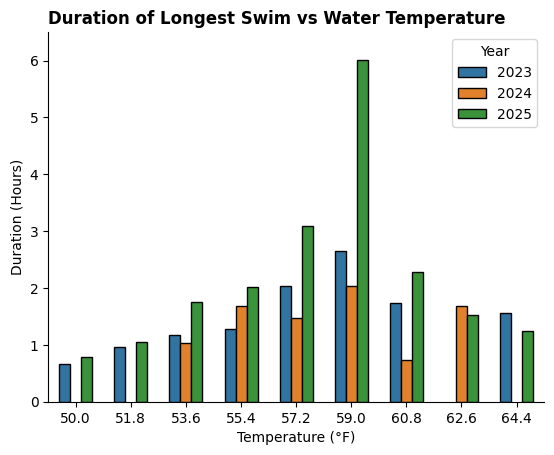

In [12]:
plot=sns.barplot(
    data=df,
    x="temp",
    y="average_swim_length",
    hue="year",
    hue_order=["2023", "2024", "2025"],
    width=0.6,
    edgecolor="black"
)
sns.despine()

plt.ylim(0, 6.5)
plt.ylabel("Duration (Hours)")
plt.xlabel("Temperature (°F)")
plt.title("Duration of Longest Swim vs Water Temperature", loc="left", fontweight="bold")
plt.legend(title="Year")

plt.show()

My cold tolerance got much better in 2025.
6 hour swim at 59°F was qualifier for my big swim that year.
2024 I was training for a warm swim (lots of pool), also was a very warm winter
Longest training swim in 2023 was ~2.5 hours at 59°F.